# ECE 657A ASSIGNMENT 1
## Heart Disease Dataset

###### Jubilee Imhanzenobe and Olohireme Ajayi

In [346]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler

In [347]:
# defining function for plotting correlation heatmap
def plot_heatmap(correlation):
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(correlation,annot=True,fmt='.3f',linewidths=0.3,annot_kws={"size": 14})
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.title('Correlation between features', fontsize=20)
    ax.figure.axes[-1].tick_params(labelsize=18) # To increase fontsize of colorbar ticks
    lim = len(correlation.columns)
    ax.set_ylim([0,lim]) # to make the map display correctly without trimming the edges
    plt.show()
    return

In [348]:
# importing the dataset
dataset = pd.read_csv("heart_disease_missing.csv")

# data feature type
bins = ['sex', 'fbs', 'exang']
cats = ['cp', 'restecg', 'slope', 'thal']
ords = ['ca']
nums = ['age', 'oldpeak', 'trestbps', 'chol', 'thalach']
target = ['target']

## Question 1

### CM1

##### Feature Selection

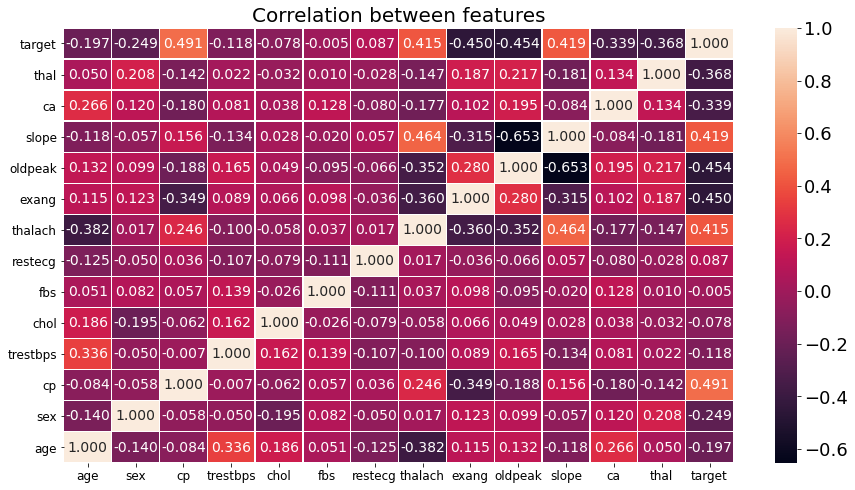

In [349]:
# using a correlation heatmap
correlation = dataset.corr()
plot_heatmap(correlation)

from the heatmap cp, oldpeak, exang, slope, thalach, thal and ca have highest correlation with target (correlation > 0.3)


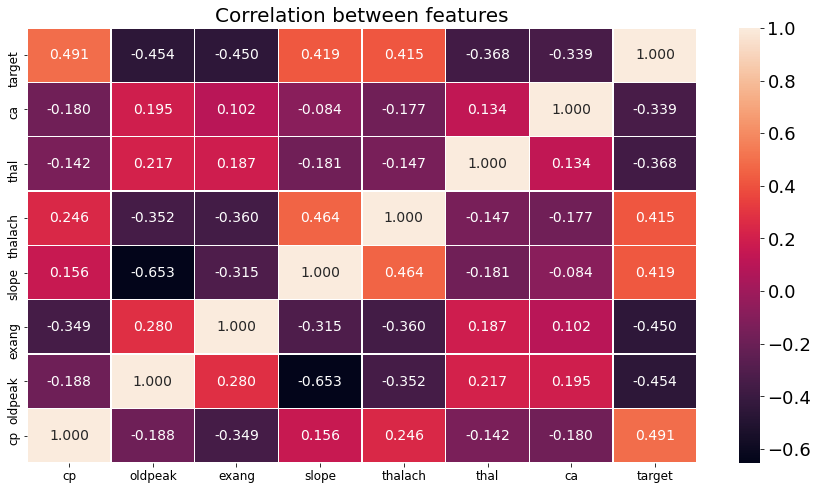

In [350]:
# closer inspection of 7 features with correlation map
plot_heatmap(dataset[['cp','oldpeak','exang','slope','thalach','thal','ca','target']].corr())

In [351]:
# checking data completeness
for column in ['cp','oldpeak','exang','slope','thalach','thal','ca']:
    print(column.upper(), "-", dataset[column].isna().sum())

CP - 0
OLDPEAK - 12
EXANG - 0
SLOPE - 2
THALACH - 4
THAL - 1
CA - 0


##### Plotting the pairs plot

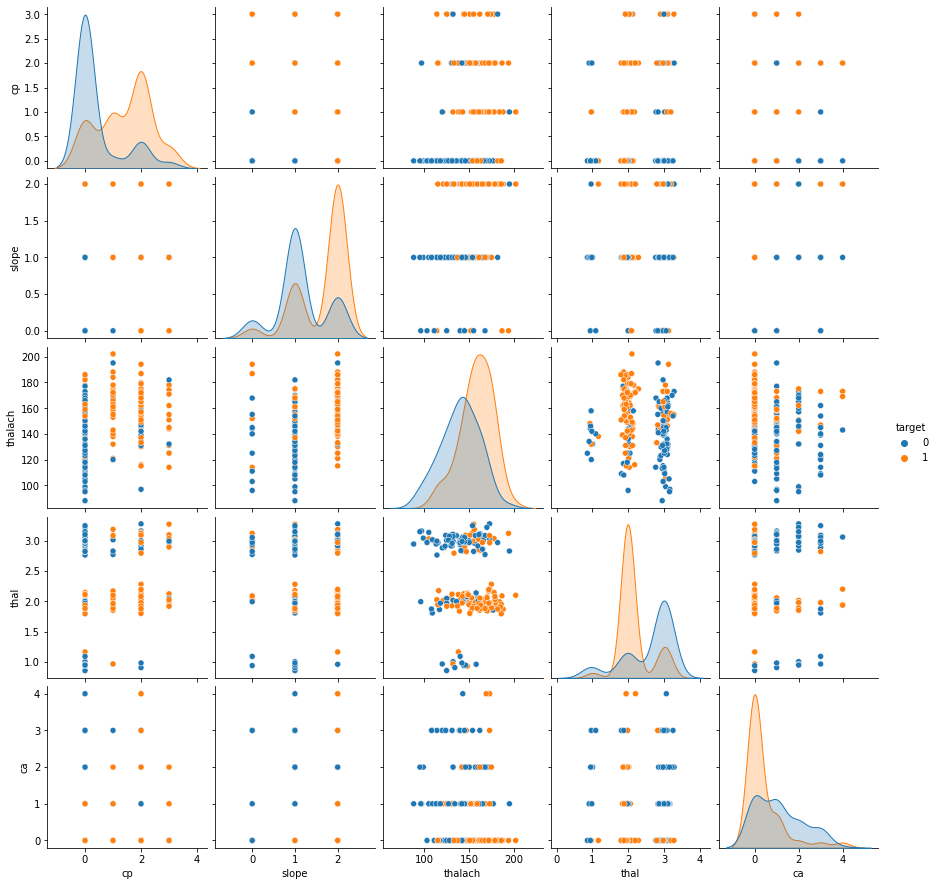

In [352]:
data = dataset[['cp', 'slope', 'thalach', 'thal','ca', 'target']]
sns.pairplot(data, hue="target")

##### Justification for feature selection

- oldpeak and slope have high interfeature correlation -0.653 so we dropped one.
- dropped oldpeak because it has a high number of missing values (accounts for about 75% of missing values in the data) 
- cp has the highest correlation with the target 0.491 so it is selected
- thal and ca have the least relative correlation with the other features so they are selected
- for the final feature, thalach is selected ahead of exang


### CM2

##### Reporting the correlation coefficient for selected features

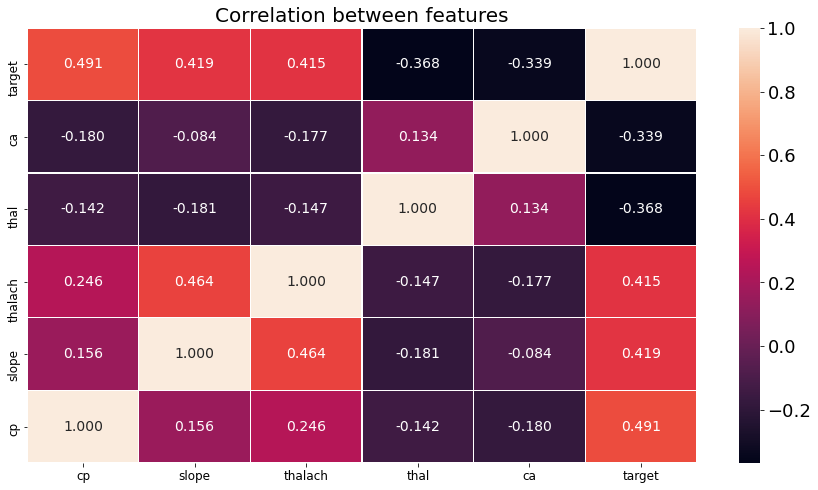

In [353]:
plot_heatmap(data.corr())

- cp has the highest correlation with the target
- thal has the highest negative correlation with the target
- cp, slope and thalach have positive correlation with the target
- thal and ca have negative correlation with the target
- the highest interfeature correlation is 0.464 and it exists between thalach and slope

##### Calculating the mean, variance, skew, kurtosis for the datasets

In [354]:
# comparing for the different target
for tar in data["target"].unique():
    print("*** Target = ", tar, "***")
    for column in data.iloc[:,:-1].columns:
        mean = round(data[data['target'] == tar][column].mean(), 2)
        variance = round(data[data['target'] == tar][column].var(), 2)
        skew = round(data[data['target'] == tar][column].skew(), 2)
        kurtosis = round(data[data['target'] == tar][column].kurt(), 2)
        print(column, "Mean -", mean)
        
        # if column is not numeric find the mode
        if column in ['cp', 'slope', 'ca']:
            mode = round(data[data['target'] == tar][column].mode()[0], 2)
            print(column, "Mode -", mode)
            
        print(column, "Variance -", variance)
        print(column, "Skew -", skew)
        print(column, "Kurtosis -", kurtosis)
        print()

*** Target =  1 ***
cp Mean - 1.42
cp Mode - 2
cp Variance - 0.88
cp Skew - -0.21
cp Kurtosis - -0.96

slope Mean - 1.66
slope Mode - 2.0
slope Variance - 0.31
slope Skew - -1.43
slope Kurtosis - 1.11

thalach Mean - 158.12
thalach Variance - 352.4
thalach Skew - -0.51
thalach Kurtosis - 0.16

thal Mean - 2.15
thal Variance - 0.2
thal Skew - 0.91
thal Kurtosis - 1.26

ca Mean - 0.41
ca Mode - 0
ca Variance - 0.79
ca Skew - 2.62
ca Kurtosis - 6.82

*** Target =  0 ***
cp Mean - 0.41
cp Mode - 0
cp Variance - 0.7
cp Skew - 1.8
cp Kurtosis - 1.84

slope Mean - 1.14
slope Mode - 1.0
slope Variance - 0.33
slope Skew - -0.0
slope Kurtosis - -0.07

thalach Mean - 139.77
thalach Variance - 466.98
thalach Skew - -0.17
thalach Kurtosis - -0.28

thal Mean - 2.59
thal Variance - 0.46
thal Skew - -1.33
thal Kurtosis - 0.61

ca Mean - 1.11
ca Mode - 0
ca Variance - 1.16
ca Skew - 0.63
ca Kurtosis - -0.65



##### Nature of the data and observations

### CM3

##### Checking for outliers

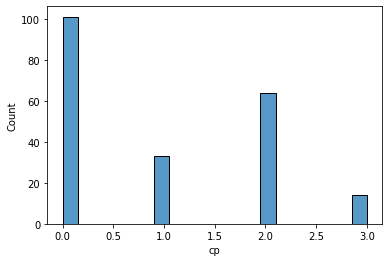

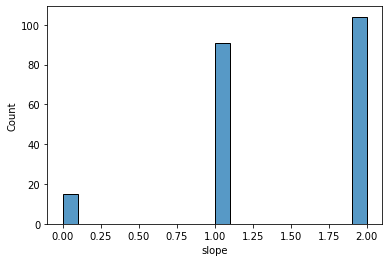

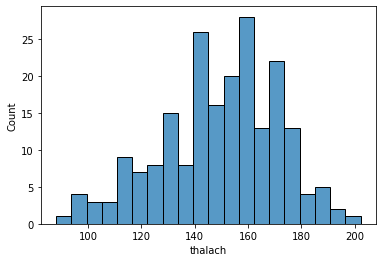

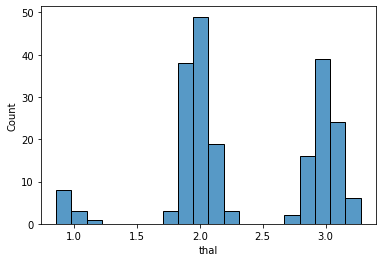

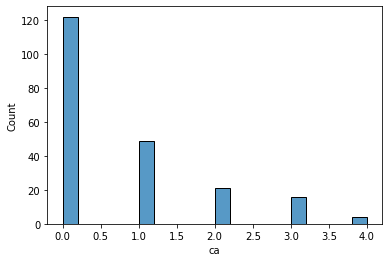

In [355]:
for column in data.iloc[:,:-1].columns:
    plt.figure()
    sns.histplot(data = data, x = column, bins = 20)
    plt.show()

from the histogram plots,
- There is noise in thal feature as it is supposed to be categorical with unique values but it has some gaussian noise.
- There are outliers in ca bacause it is a categorical variable with range 0 to 3 and there are few observations with a value of 4.

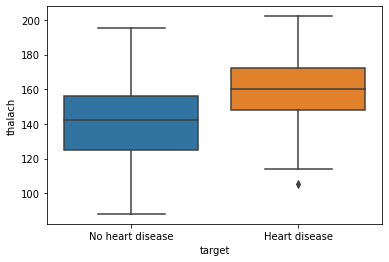

In [356]:
# finer detection using box plot (mainly for numerical columns)
for column in data.columns[:-1]:
    if column in nums:
        ax = sns.boxplot(x="target", y=column, data=data)
        ax.set_xticks(range(2))
        ax.set_xticklabels(['No heart disease','Heart disease'])
        plt.show()

The boxplot shows the presence of an outlier in the thalach feature

In [357]:
"""# Handling Outliers in thalach by replacing with nan using z-score method
outliers = {}
for column in nums:
    if column in data.columns:
        mean = data[column].mean() 
        std = data[column].std()`
        threshold = 3
        outlier = [] 
        for row in data[column]: 
            z = abs((row - mean) / std)
            if z > threshold:
                data.loc[row, column] = np.nan
                outlier.append(i) 
        if outlier:
            outliers[column] = outlier"""

'# Handling Outliers in thalach by replacing with nan using z-score method\noutliers = {}\nfor column in nums:\n    if column in data.columns:\n        mean = data[column].mean() \n        std = data[column].std()`\n        threshold = 3\n        outlier = [] \n        for row in data[column]: \n            z = abs((row - mean) / std)\n            if z > threshold:\n                data.loc[row, column] = np.nan\n                outlier.append(i) \n        if outlier:\n            outliers[column] = outlier'

In [358]:
for column in data.columns[:-1]:
    if column in nums:
        for label in [0,1]:
            Q1 = data[column][data["target"] == label].quantile(0.25)
            Q3 = data[column][data["target"] == label].quantile(0.75)
            IQR = Q3 - Q1 #Interquartile range
            fence_low = Q1 - (1.5 * IQR)
            fence_high = Q3 + (1.5 * IQR)

            df2 = pd.DataFrame(data[data['target'] == label][column])

            for index in df2[df2[column] < fence_low].index:
                data.drop(index, inplace=True)
                data.reset_index(drop=True, inplace = True)
                #data.loc[index, column] = np.nan
            for index in df2[df2[column] > fence_high].index:
                data.loc[index, column] = np.nan

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


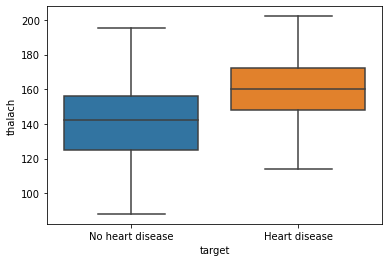

In [359]:
# Replotting box plot to confirm outlier removal
ax = sns.boxplot(x="target", y="thalach", data=data)
ax.set_xticks(range(2))
ax.set_xticklabels(['No heart disease','Heart disease'])
plt.show()

### CM4

##### Grouping the features by their variable types and plotting a histogram of the features

In [360]:
# creating a list of the variable types
cats = ['cp', 'thal', 'slope']
ords = ['ca']
nums = ['thalach']
target = ['target']

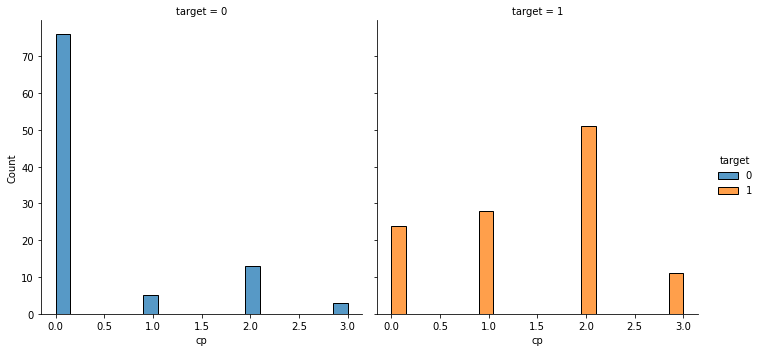

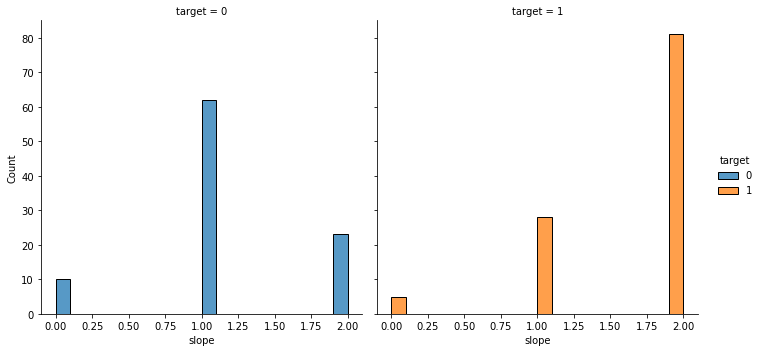

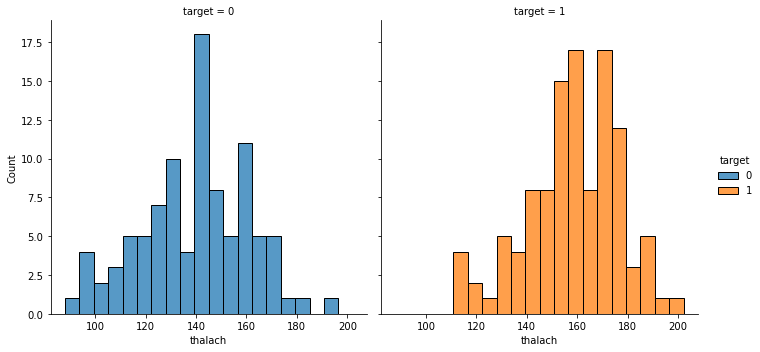

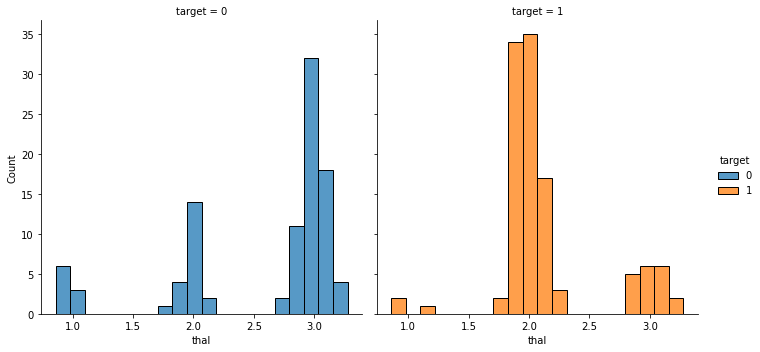

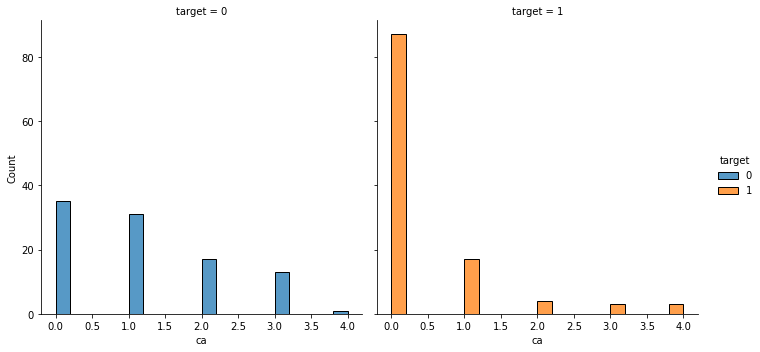

In [361]:
# plotting the histogram
for feature in data.columns[:-1]:
    sns.displot(data, x = feature, bins = 20, col = 'target', hue = 'target')

### CM5

##### Data Cleaning

In [362]:
# Handling Outliers
outlier_index = data[data["ca"] == 4].index
data.drop(outlier_index, inplace = True)
data.reset_index(drop = True)

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,cp,slope,thalach,thal,ca,target
0,2,1.0,115.952071,2.175904,0,1
1,0,1.0,135.970028,3.082071,0,0
2,2,2.0,152.210039,2.020827,0,0
3,2,1.0,143.049207,2.100312,0,1
4,0,1.0,143.099327,2.831509,1,0
...,...,...,...,...,...,...
202,2,1.0,141.981335,0.983927,1,0
203,0,2.0,158.992132,1.884149,1,1
204,2,2.0,164.977674,2.970521,0,1
205,2,1.0,167.851493,1.879487,0,1


There are outliers in ca bacause it is a categorical variable with range 0 to 3 and there are few observations with a value of 4. These outliers have been replaced with the mode of the ca feature grouped by the target.
The observed outliers in oldpeak were replaced with missing values and will be handled in the next step

In [363]:
# checking for missing values in columns
for column in data.columns:
    print(column.upper(), "-", data[column].isna().sum())

CP - 0
SLOPE - 2
THALACH - 4
THAL - 1
CA - 0
TARGET - 0


In [364]:
# checking for missing values in rows
for i in range(len(data)):
    row = data.iloc[i, :]
    if row.isna().sum() > 0:
        print(i , ": ", row.isna().sum())

5 :  1
17 :  1
26 :  1
80 :  1
118 :  1
172 :  1
198 :  1


for the different features, thalach has the highest number of missing values
no row has more than 1 missing value so we can use estimation method for the missing values. If any row had more than 1 missing values, the row would have been dropped

In [365]:
# Handling missing values for categorical features
nan_index = data['thal'].index[data['thal'].apply(np.isnan)]
data.drop(nan_index, inplace = True)
data.reset_index(drop = True)
data['thal'] = data['thal'].astype(int)
for column in cats:
    if column in data.columns:
        group_mode = data[[column, "target"]].groupby("target").agg(lambda x:x.value_counts().index[0])
        for index in data[data[column].isna()].index:
            target = data.iloc[index, -1]   
            data[column][index] = group_mode[column][target]

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\jubil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\jubil\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added ba

In [366]:
# Handling missing values for numeric features
group_mean = data.groupby("target").mean()
for column in data.columns:
    for index in data[data[column].isna()].index:
        target = data.iloc[index,-1]
        if (data[column].max() - data[column].min() > 5) or data[column].dtype == "float64":
            data[column][index] = round(group_mean[column][target], 2)

C:\Users\jubil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


The approximation method used in replacing missing values was using the mean of the feature grouped by the target for numeric features oldpeak and thalac. For categorical feature thal, the missing value was replaced with the mode of the feature grouped by the target.

##### Plotting the correlation plot to see the effect of data cleaning on the dataset

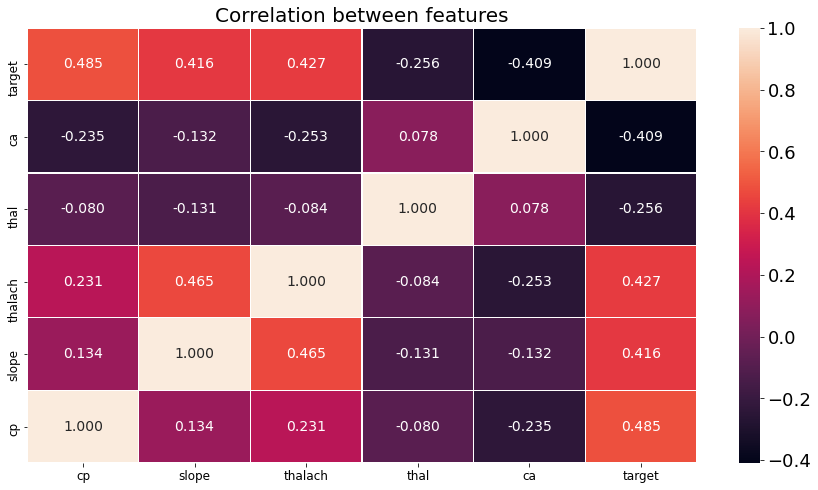

In [367]:
plot_heatmap(data.corr())

After Data cleaning
- The correlation between slope and target decreased from 0.419 to 0.416
- The correlation between thalach and target increased from 0.415 to 0.427
- The correlation between ca and target increased from -0.339 to -0.409
- The correlation between thal and target decreased from -0.368 to - 0.256
- The correlation between cp and target decreased from 0.491 to 0.485


In [368]:
# Replacing categorical variables with descriptions
data.cp = data.cp.replace({0:'Asympt.', 1:'Atypical', 2:'Non', 3:'Typical'})
data.thal = data.thal.replace({0:'NA', 1:'Fixed', 2:'Normal', 3:'Reverse'})
data.slope = data.slope.replace({0:'down', 1:'up', 2:'flat'})

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Question 2 

### Building the KNN Model

In [369]:
# One hot encoding categorical features
categorical_cols = ['cp', 'thal', 'slope'] 

df = pd.get_dummies(data.iloc[:,:-1], columns = categorical_cols)
df["target"] = data["target"]
data = df

In [370]:
data.head()

,thalach,ca,cp_Asympt.,cp_Atypical,cp_Non,cp_Typical,thal_Fixed,thal_NA,thal_Normal,thal_Reverse,slope_down,slope_flat,slope_up,target
0,115.952071,0,0,0,1,0,0,0,1,0,0,0,1,1
1,135.970028,0,1,0,0,0,0,0,0,1,0,0,1,0
2,152.210039,0,0,0,1,0,0,0,1,0,0,1,0,0
3,143.049207,0,0,0,1,0,0,0,1,0,0,0,1,1
4,143.099327,1,1,0,0,0,0,0,1,0,0,0,1,0


In [371]:
# separating ths dataset into matrix of features and target
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Splitting the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=275)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=275)

In [372]:
# Developing the Classification Model
classifier = KNeighborsClassifier()
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)

# Evaluating the Model
cm = confusion_matrix(y_test,y_pred)

accuracy_1 = round(100 * accuracy_score(y_test,y_pred), 2)
f1_score_1 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
auc_1 = round(roc_auc_score(y_test, y_pred, average = "macro", multi_class = "ovo"), 2)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, y_pred_train), 2))
print("F1_score: ", round(f1_score(y_train, classifier.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, classifier.predict(X_train), average = "macro", multi_class = "ovo"), 2))
print()
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)
print("F1_score: ", f1_score_1)
print("AUC: ", auc_1)

Training Set Evaluation
Accuracy:  81.3
F1_score:  0.81
AUC:  0.81

Test Set Evaluation
Accuracy:  73.81
F1_score:  0.74
AUC:  0.74


##### Finding best parameter by tuning k

In [373]:
k_list = [1,5,10,15,20,25,30,35]

accuracy = {}
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train,y_train)
    
    # Predicting the test set result
    y_pred = classifier.predict(X_val)
    
    model_accuracy = accuracy_score(y_val, y_pred)
    
    accuracy[k] = round(model_accuracy * 100, 2)

### CM6

<AxesSubplot:>

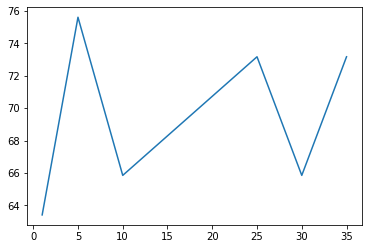

In [374]:
# plotting the parameter vs accuracy graph
sns.lineplot(x = k_list, y = accuracy.values())

The highest accuracy accurs at k = 1 but we will select k = 25 as the optimal k because in KNN, a small value of k will make our model highly susceptible to noise which will cause high variations in the performance of the model on different sets of unobserved data

##### Building the model with optimal k

In [375]:
k_opt = 25
classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)

# Evaluating the model
accuracy_2 = round(100 * accuracy_score(y_test, y_pred), 2)
f1_score_2 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
auc_2 = round(roc_auc_score(y_test, y_pred, average = "macro", multi_class = "ovo"), 2)

print("Test Set Evaluation")
print("Accuracy: ", accuracy_2)
print("F1_score: ", f1_score_2)
print("AUC: ", auc_2)
print()
print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, classifier.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, classifier.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, classifier.predict(X_train), average = "macro", multi_class = "ovo"), 2))
print()
print("Validation Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_val, classifier.predict(X_val)), 2))
print("F1_score: ", round(f1_score(y_val, classifier.predict(X_val), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_val, classifier.predict(X_val), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  66.67
F1_score:  0.66
AUC:  0.65

Training Set Evaluation
Accuracy:  65.04
F1_score:  0.65
AUC:  0.65

Validation Set Evaluation
Accuracy:  73.17
F1_score:  0.74
AUC:  0.74


##### Improving the model

In [376]:
data.head()

,thalach,ca,cp_Asympt.,cp_Atypical,cp_Non,cp_Typical,thal_Fixed,thal_NA,thal_Normal,thal_Reverse,slope_down,slope_flat,slope_up,target
0,115.952071,0,0,0,1,0,0,0,1,0,0,0,1,1
1,135.970028,0,1,0,0,0,0,0,0,1,0,0,1,0
2,152.210039,0,0,0,1,0,0,0,1,0,0,1,0,0
3,143.049207,0,0,0,1,0,0,0,1,0,0,0,1,1
4,143.099327,1,1,0,0,0,0,0,1,0,0,0,1,0


In [377]:
# Normalizing numerical features
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In feature scaling, the data was normalized with standardscaler as thalach is a numerical feature in the data and it has a higher scale compared to the other features used in the model.

##### parameter tuning of weight and distance metrics

In [378]:
# finding optimal distance metric
weights = ["uniform", "distance"]
distance_metrics = [1, 2]
evaluation = []

for weight in weights:
    for p in distance_metrics:     
        classifier = KNeighborsClassifier(n_neighbors = k_opt, weights = weight, p = p)
        classifier.fit(X_train,y_train)

        # Testing on the validation set
        y_pred = classifier.predict(X_val)

        # Evaluating the model
        accuracy_3 = round(100 * accuracy_score(y_val, y_pred), 2)
        f1_score_3 = round(f1_score(y_val, y_pred, average = "weighted"), 2)
        auc_3 = round(roc_auc_score(y_val, y_pred, average = "macro", multi_class = "ovo"), 2)
        
        evaluation.append({'weight':weight, 'p':p, 'accuracy':accuracy_3, 'F1':f1_score_3, 'AUC':auc_3})

In [379]:
for eval in evaluation:
    print(eval)

{'weight': 'uniform', 'p': 1, 'accuracy': 85.37, 'F1': 0.85, 'AUC': 0.82}
{'weight': 'uniform', 'p': 2, 'accuracy': 82.93, 'F1': 0.83, 'AUC': 0.81}
{'weight': 'distance', 'p': 1, 'accuracy': 78.05, 'F1': 0.79, 'AUC': 0.77}
{'weight': 'distance', 'p': 2, 'accuracy': 80.49, 'F1': 0.81, 'AUC': 0.79}


##### Building the optimized model  (uniform weight and manhattan distance)

In [380]:
classifier = KNeighborsClassifier(n_neighbors = k_opt, weights = "uniform", p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

### CM7

In [381]:
# Predicting the test set result with optimized model
y_pred = classifier.predict(X_test)

# Evaluating the model
accuracy_4 = round(100 * accuracy_score(y_test, y_pred), 2)
f1_score_4 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
auc_4 = round(roc_auc_score(y_test, y_pred, average = "macro", multi_class = "ovo"), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_4)
print("F1_score: ", f1_score_4)
print("AUC: ", auc_4)
print()
print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, classifier.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, classifier.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, classifier.predict(X_train), average = "macro", multi_class = "ovo"), 2))
print()
print("Validation Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_val, classifier.predict(X_val)), 2))
print("F1_score: ", round(f1_score(y_val, classifier.predict(X_val), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_val, classifier.predict(X_val), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  92.86
F1_score:  0.93
AUC:  0.92

Training Set Evaluation
Accuracy:  83.74
F1_score:  0.84
AUC:  0.84

Validation Set Evaluation
Accuracy:  82.93
F1_score:  0.83
AUC:  0.81


# Kaggle Submission

In [382]:
test_data = pd.read_csv("test.csv")
test_data = test_data[['cp','slope','thalach','thal','ca']]
test_data = pd.get_dummies(test_data, columns = categorical_cols)
test_data

,thalach,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,167,0,0,0,1,0,0,0,1,0,0,0,1
1,181,0,1,0,0,0,0,0,0,1,0,0,1
2,142,1,1,0,0,0,0,0,0,1,0,1,0
3,111,0,1,0,0,0,0,0,0,1,0,0,1
4,145,2,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,163,0,0,0,1,0,0,0,1,0,0,0,1
87,172,0,0,1,0,0,0,0,1,0,0,0,1
88,173,0,0,0,1,0,0,0,1,0,0,1,0
89,126,0,1,0,0,0,0,0,0,1,0,1,0


In [383]:
"""X_train = X
y_train = y

X_train = X_scaler.fit_transform(X_train)

X_test = test_data.values
X_test = X_scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors = k_opt, weights = "uniform", p = 2)
classifier.fit(X_train, y_train)

# Predicting the test set result with optimized model
y_pred = classifier.predict(X_test)

result = pd.DataFrame(columns=['id','target'])
result['id'] = test_data.index
result['target'] = y_pred

result.set_index(keys='id', inplace=True)

result.to_csv('submission_1.csv')"""

'X_train = X\ny_train = y\n\nX_train = X_scaler.fit_transform(X_train)\n\nX_test = test_data.values\nX_test = X_scaler.transform(X_test)\n\nclassifier = KNeighborsClassifier(n_neighbors = k_opt, weights = "uniform", p = 2)\nclassifier.fit(X_train, y_train)\n\n# Predicting the test set result with optimized model\ny_pred = classifier.predict(X_test)\n\nresult = pd.DataFrame(columns=[\'id\',\'target\'])\nresult[\'id\'] = test_data.index\nresult[\'target\'] = y_pred\n\nresult.set_index(keys=\'id\', inplace=True)\n\nresult.to_csv(\'submission_1.csv\')'